# Classification of cats based on their meows

In [38]:
import librosa
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Define procedures

### 1. Extracting features from audio file used later for classification

In [39]:
def extract_features_from_waveform(data, sr):
    """
    Extracts features from a raw audio waveform.
    """
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=13).mean(axis=1)

    # Extract Chroma features
    chroma = librosa.feature.chroma_stft(y=data, sr=sr).mean(axis=1)

    # Extract Spectral Contrast
    spectral_contrast = librosa.feature.spectral_contrast(y=data, sr=sr).mean(axis=1)

    # Combine all features
    return np.hstack([mfccs, chroma, spectral_contrast])

In [40]:
def cleanse_audio(file_path, target_sample_rate=16000):
    """
    Cleanses the audio file by performing the following:
    - Resampling to the target sample rate
    - Normalization
    - Trimming silence
    """
    # Load audio file
    data, sr = librosa.load(file_path, sr=None)

    # Trim silence from the beginning and end
    data, _ = librosa.effects.trim(data)

    # Resample to the target sample rate
    if sr != target_sample_rate:
        data = librosa.resample(data, orig_sr=sr, target_sr=target_sample_rate)
        sr = target_sample_rate

    # Normalize the audio to range [-1, 1]
    data = librosa.util.normalize(data)

    return data, sr

### Preprocess data

In [41]:
DATA_DIR = "../dataanalysis/dataset/dataset/"
audio_files = os.listdir(DATA_DIR)

# Prepare labels
emission_context = {'F': 'Waiting For Food', 'I': 'Isolated in unfamiliar Environment', 'B': 'Brushing'}
breed_map = {'MC': 'Maine Coon', 'EU': 'European Shorthair'}
sex_map = {'FI': 'Female Intact', 'FN': 'Female Neutralised', 'MI': 'Male Intact', 'MN':'Male Neutralised'}


data = []
for file in audio_files:
    split = file.split('_')
    label_context = split[0]
    label_breed = split[2]
    label_sex = split[3]
    
    file_path = os.path.join(DATA_DIR, file)

    # Load and cleanse audio
    audio_data, sr = cleanse_audio(file_path)

    # Extract features for the original audio
    features = extract_features_from_waveform(audio_data, sr)
    data.append([features, label_context, label_breed, label_sex])

    # Augment male cat data
    if label_sex in ['MI', 'MN']:
        # Apply pitch shifting
        data_shifted = librosa.effects.pitch_shift(audio_data, sr=sr, n_steps=2)
        features_shifted = extract_features_from_waveform(data_shifted, sr)
        
        # Add the pitch-shifted features
        data.append([features_shifted, label_context, label_breed, label_sex])


# Convert to DataFrame
df = pd.DataFrame(data, columns=['features', 'emission_context', 'breed', 'sex'])

In [42]:
df[:][:]

,features,emission_context,breed,sex
0,"[-349.7370300292969, 97.11997985839844, -74.09...",B,MC,MN
1,"[-367.95574951171875, 82.39789581298828, -83.3...",B,MC,MN
2,"[-344.1110534667969, 104.6786117553711, -75.60...",B,MC,MN
3,"[-362.3681640625, 97.22762298583984, -90.47682...",B,MC,MN
4,"[-374.1191711425781, 105.55970764160156, -68.7...",B,MC,MN
...,...,...,...,...
510,"[-300.8938903808594, 94.4280776977539, -66.569...",I,MC,FI
511,"[-310.45660400390625, 93.56620788574219, -70.3...",I,MC,FI
512,"[-254.23939514160156, 99.22516632080078, -71.9...",I,MC,FI
513,"[-281.2156066894531, 103.79820251464844, -78.7...",I,MC,FI


In [43]:
from sklearn.model_selection import train_test_split

# Separate features (X) and labels (y)
X = np.array(df['features'].tolist())  # Convert list of features to a 2D numpy array
y = df['sex']

# Encode labels (e.g., MI -> 0, MN -> 1, etc.)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [44]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [45]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),  # Input layer
    layers.Dense(128, activation='relu'),  # Fully connected layer
    layers.Dropout(0.3),  # Dropout to prevent overfitting
    layers.Dense(64, activation='relu'),  # Second dense layer
    layers.Dropout(0.3),
    layers.Dense(len(np.unique(y)), activation='softmax')  # Output layer with softmax for classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               4224      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 4)                 260       
                                                                 
Total params: 12740 (49.77 KB)
Trainable params: 12740 (49.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,  # Stop training if validation loss doesn't improve for 5 epochs
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping]
)

Epoch 1/100
23/23 [==============================] - 2s 32ms/step - loss: 1.2793 - accuracy: 0.4556 - val_loss: 1.0422 - val_accuracy: 0.6494
Epoch 2/100
23/23 [==============================] - 1s 42ms/step - loss: 0.9330 - accuracy: 0.6306 - val_loss: 0.8690 - val_accuracy: 0.6623
Epoch 3/100
23/23 [==============================] - 1s 42ms/step - loss: 0.7758 - accuracy: 0.6861 - val_loss: 0.7805 - val_accuracy: 0.6883
Epoch 4/100
23/23 [==============================] - 1s 47ms/step - loss: 0.7086 - accuracy: 0.7278 - val_loss: 0.7130 - val_accuracy: 0.7662
Epoch 5/100
23/23 [==============================] - 1s 44ms/step - loss: 0.6716 - accuracy: 0.7528 - val_loss: 0.6520 - val_accuracy: 0.7922
Epoch 6/100
23/23 [==============================] - 1s 41ms/step - loss: 0.5843 - accuracy: 0.7639 - val_loss: 0.6140 - val_accuracy: 0.8052
Epoch 7/100
23/23 [==============================] - 1s 42ms/step - loss: 0.5224 - accuracy: 0.8139 - val_loss: 0.5958 - val_accuracy: 0.8052
Epoch 

In [47]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

3/3 [==============================] - 0s 29ms/step - loss: 0.3498 - accuracy: 0.8718
Test Loss: 0.3498
Test Accuracy: 0.8718


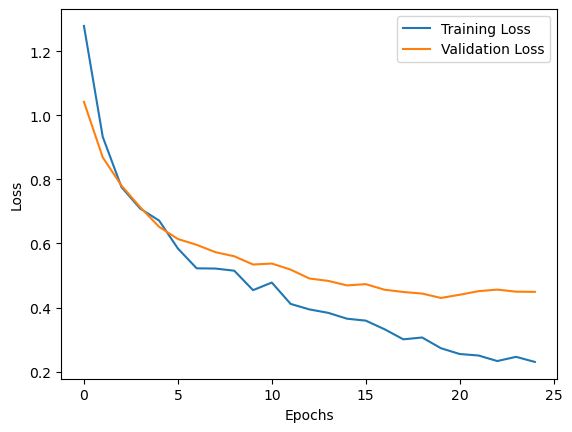

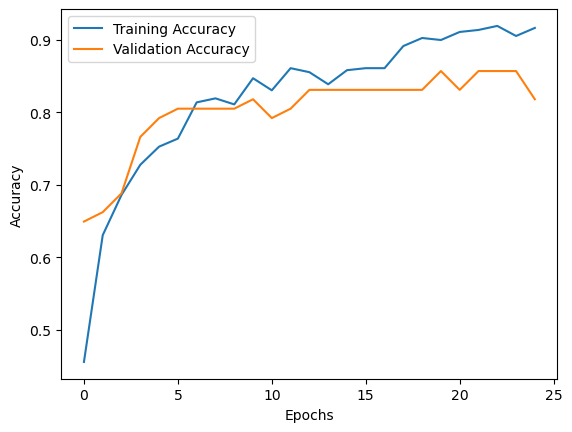

In [48]:
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [49]:
def preprocess_single_audio(file_path, target_sample_rate=16000):
    """
    Preprocess a single audio file and extract the features for classification.
    """
    # Cleanse the audio (e.g., trimming, resampling, normalization)
    data, sr = cleanse_audio(file_path, target_sample_rate=target_sample_rate)

    # Extract features (MFCCs, Chroma, Spectral Contrast)
    features = extract_features(file_path, target_sample_rate=target_sample_rate)

    # Normalize the features
    scaler = StandardScaler()
    features = scaler.fit_transform(features.reshape(-1, 1)).flatten()  # Normalize across the feature set

    return features

In [52]:
def classify_audio(file_path, model, scaler, label_encoder, target_sample_rate=16000):
    """
    Classify a single audio file using the trained model.
    """
    # Preprocess the audio file
    features = preprocess_single_audio(file_path, target_sample_rate)

    # Reshape the features to match the model's input shape
    features = features.reshape(1, -1)  # Reshape for a single sample (1, number_of_features)

    # Make prediction
    prediction = model.predict(features)

    # If using a softmax output, we get probabilities, so we need the index with the highest probability
    predicted_class_idx = np.argmax(prediction, axis=1)  # Get the index of the highest probability

    # Decode the predicted label
    predicted_label = label_encoder.inverse_transform(predicted_class_idx)
    
    return predicted_label[0]

In [54]:
TEST_DIR = "../dataanalysis/dataset/testset/"
test_files = os.listdir(TEST_DIR)

for file in test_files:
    file_path = os.path.join(TEST_DIR, file)
    predicted_sex = classify_audio(file_path, model, scaler, label_encoder)
    print(f"{file}: {predicted_sex}")

1/1 [==============================] - 0s 17ms/step
B_ANI01_MC_FN_SIM01_101.wav: MN
1/1 [==============================] - 0s 14ms/step
B_ANI01_MC_FN_SIM01_102.wav: MN
1/1 [==============================] - 0s 17ms/step
B_ANI01_MC_FN_SIM01_103.wav: MN
1/1 [==============================] - 0s 14ms/step
B_ANI01_MC_FN_SIM01_301.wav: MN
1/1 [==============================] - 0s 14ms/step
B_ANI01_MC_FN_SIM01_302.wav: MN
1/1 [==============================] - 0s 14ms/step
B_ANI01_MC_FN_SIM01_303.wav: MN
1/1 [==============================] - 0s 14ms/step
B_NIG01_MC_MN_SIM01_101.wav: MN
1/1 [==============================] - 0s 17ms/step
B_NIG01_MC_MN_SIM01_102.wav: MN
1/1 [==============================] - 0s 15ms/step
B_NIG01_MC_MN_SIM01_103.wav: MN
1/1 [==============================] - 0s 14ms/step
B_NIG01_MC_MN_SIM01_201.wav: MN
1/1 [==============================] - 0s 17ms/step
I_ANI01_MC_FN_SIM01_101.wav: MN
1/1 [==============================] - 0s 13ms/step
I_ANI01_MC_FN_SIM01_102.